In [89]:
import gym
import matplotlib.pyplot as plt
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
lookback=5

class Chembarambaakam(gym.Env):
        metadata = {
            'render.modes': ['human']
        }


        def step(self, a):
            self.action=a
            outflow_factor=0.0864
            inflow_factor=0.0864
            EVAPORATION=0#-raw.iloc[self.count+lookback,2]
            if(self.count%365<175 and self.count%365>20):
                EVAPORATION=0
            #if(raw.iloc[self.count+lookback,2]==0):
                #EVAPORATION=np.random.random(1)*2+2

            res=self.state[4][0]-EVAPORATION+(raw.iloc[lookback+self.count,1]* inflow_factor)-(raw.iloc[lookback+self.count,3]* outflow_factor)
            if(res<0):
                res=0
            nextt=np.array(self.state[1:]).tolist()
            nextt.append([res,raw.iloc[lookback+self.count,1],raw.iloc[lookback+self.count,3],self.action])
            self.state=np.array(nextt)

            if(self.action<self.DEMAND_THRESHOLD):
                self.bad_day+=1
                self.reward=-1
            elif(res>3000):
                self.bad_day+=1
                self.reward=-1
            else:
                self.good_day+=1
                self.reward=0

            self.count+=1

            return self.state, -self.reward, self.count>=len(raw)-lookback, {}


        def __init__(self, seed=0):
            self.DEMAND_THRESHOLD=120
            self.MAX_CAPACITY=3000
            self.action = 0.
            self.count = seed
            self.good_day = 0
            self.bad_day = 0
            self.reward=0


            lookback=5
            self.next_state=np.zeros((lookback,raw.shape[-1]))

            sequence=np.zeros((lookback,raw.shape[-1]))
            for j in range(0,lookback):
                    sequence[j]=raw.loc[seed+j,:]
            self.state = sequence

            a=[]
            for i in range(lookback):
                a.append([0., 0.,0., 0.])
            self.low=np.array(a, dtype=np.float32)

            a=[]
            for i in range(lookback):
                a.append([4000., 100000.,1000., 100000.])
            self.high=np.array(a, dtype=np.float32)
            self.action_space = spaces.Box(
                low=0,
                high=100000, shape=(1,),
                dtype=np.uint8
            )
            self.observation_space = spaces.Box(
                low=self.low,
                high=self.high,
                dtype=np.float32
            )


        def reset(self,seed=0):
            self.DEMAND_THRESHOLD=120
            self.MAX_CAPACITY=3000
            self.action = 0.
            self.count = seed
            self.good_day = 0
            self.bad_day = 0
            self.reward=0
            self.next_state=np.zeros((lookback,raw.shape[-1]))
            sequence=np.zeros((lookback,raw.shape[-1]))
            for j in range(0,lookback):
                    sequence[j]=raw.loc[seed+j,:]
            self.state = sequence
            return self.state


        def render(self, mode='human'):
            ;


In [90]:
import pandas as pd
import numpy as np
dianna=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\dianna.csv',parse_dates={'date' : ['Date']},na_values=-1)
dianna.info()
dianna.dropna(inplace=True)
dianna=dianna.reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5844 entries, 0 to 5843
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              5844 non-null   datetime64[ns]
 1   nth day in year   5844 non-null   int64         
 2   Storage (mcft)    5830 non-null   float64       
 3   Inflow (cusecs)   5830 non-null   float64       
 4   Rainfall (mm)     5830 non-null   float64       
 5   Outflow (cusecs)  5816 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 274.1 KB


In [91]:
raw=dianna.drop(columns=['index','date','nth day in year'])

In [92]:
env3=Chembarambaakam()
from keras.layers import LSTM,Dense,Input,Add,Flatten
from keras import optimizers
from keras.models import Model
state_input = Input(shape=env3.observation_space.shape)
lstm = Dense(32,activation='relu')(state_input)
outd= Dense(1)(lstm)
out=Flatten()(outd)
hidden2=Dense(16,activation='relu')(out)

state_input2 = Input(shape=env3.observation_space.shape)
hiddenn1=Flatten()(state_input2)
hidden1=Dense(16,activation='relu')(hiddenn1)

student=Model(input=state_input,output=out)
student.name='student'


student.compile(loss='mae', optimizer=optimizers.RMSprop())





merged    = Add()([hidden1, hidden2])
merged_h1 = Dense(8, activation='relu')(merged)
output = Dense(1, activation='relu')(merged_h1)
teacher  = Model(input=[state_input,state_input2], 
            output=output)

teacher.compile(loss='mae', optimizer=optimizers.RMSprop())
teacher.name='teacher' 

C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  from ipykernel import kernelapp as app
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [93]:
teacher.summary()

Model: "teacher"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 5, 4)         0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 5, 32)        160         input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 5, 4)         0                                            
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 5, 1)         33          dense_43[0][0]                   
____________________________________________________________________________________________

In [94]:
student.summary()

Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 5, 4)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 5, 32)             160       
_________________________________________________________________
dense_44 (Dense)             (None, 5, 1)              33        
_________________________________________________________________
flatten_15 (Flatten)         (None, 5)                 0         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [95]:
env=Chembarambaakam()
env2=Chembarambaakam()
lookback=5
num_episodes=1
print('processing....')
for ds in range(0,num_episodes):
        if(ds%100)==0:
            print('\nEpsisode: ',ds,end='')
        else:
            print('->',end='')
        state = env.reset()
        state2= env2.reset()
        #state = np.reshape(state, [1, observation_space])
        epsilon=0.95
        decay=0.999998
        gamma=0.95
        done=False
        c=[]
        igh=0
        for _ in range(lookback):
            c.append(0.0)
        while not done:
            
            #print('o')
            if(decay>0 and np.random.random()<epsilon/decay):
                action=np.random.random()*env.action_space.high[0]
                decay*=decay
            else:
                action = student.predict(np.array([state]))[0][0]
               
            state_next, reward, done, _ = env.step(action)
            
            #print(env.count)
            if(done):
                break
            action2 = student.predict(np.array([state_next]))[0][0]
            env2.state=state_next
            _,reward2, _, _=env2.step(action2)
            q_value= reward + gamma *reward2      
            teacher.fit([np.array([state]),np.array([state])],np.array([0]),epochs=1,verbose=0,batch_size=1)
            state=state_next
            igh+=1
            c.append(action)
            
            

processing....

Epsisode:  0

In [96]:
env=Chembarambaakam()
env2=Chembarambaakam()
lookback=5
num_episodes=10
print('processing....')
for ds in range(0,num_episodes):
        if(ds%100)==0:
            print('\nEpsisode: ',ds,end='')
        else:
            print('->',end='')
        state = env.reset()
        state2= env2.reset()
        #state = np.reshape(state, [1, observation_space])
        epsilon=0.95
        decay=0.999998
        gamma=0.95
        done=False
        #c=[]
        igh=0
        #for _ in range(lookback):
            #c.append(0.0)
        while not done:
            
            #print('o')
            if(decay>0 and np.random.random()<epsilon/decay):
                action=np.random.random()*env.action_space.high[0]
                decay*=decay
            else:
                action = student.predict(np.array([state]))[0][0]
               
            state_next, reward, done, _ = env.step(action)
            
            #print(env.count)
            if(done):
                break
            action2 = student.predict(np.array([state_next]))[0][0]
            env2.state=state_next
            _,reward2, _, _=env2.step(action2)
            q_value= reward + gamma *reward2      
            teacher.fit([np.array([state]),np.array([state])],np.array([q_value]),epochs=1,verbose=0,batch_size=1)
            state=state_next
            igh+=1
            #c.append(action)
            
            

processing....

Epsisode:  0->->->->->->->->->

In [97]:
env.count,len(c)

(5811, 5815)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5816 entries, 0 to 5843
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              5816 non-null   datetime64[ns]
 1   nth day in year   5816 non-null   int64         
 2   Storage (mcft)    5816 non-null   float64       
 3   Inflow (cusecs)   5816 non-null   float64       
 4   Rainfall (mm)     5816 non-null   float64       
 5   Outflow (cusecs)  5816 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 318.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Storage (mcft)    5816 non-null   float64
 1   Inflow (cusecs)   5816 non-null   float64
 2   Rainfall (mm)     5816 non-null   float64
 3   Outflow (cusecs)  5816 non-null   float64
dty

<Figure size 432x288 with 0 Axes>

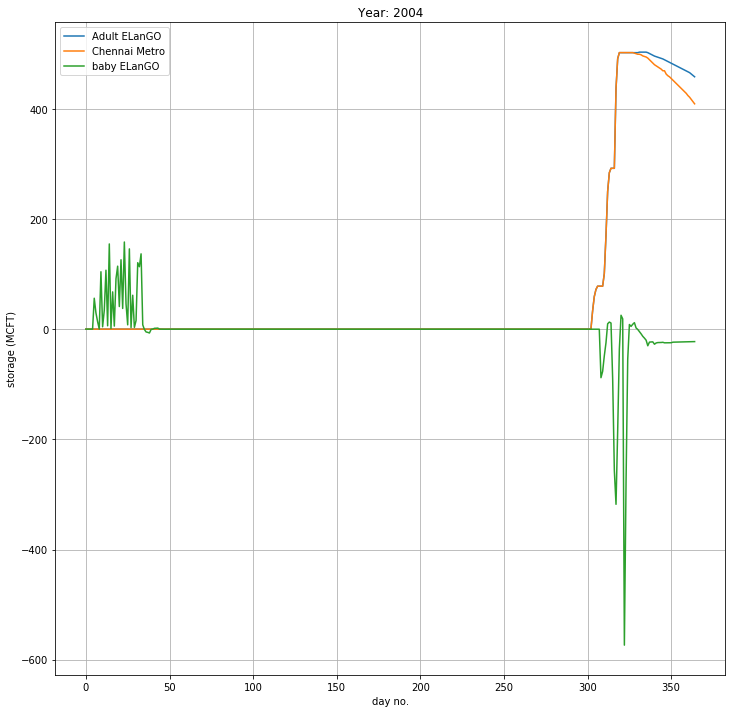

Progress: ------

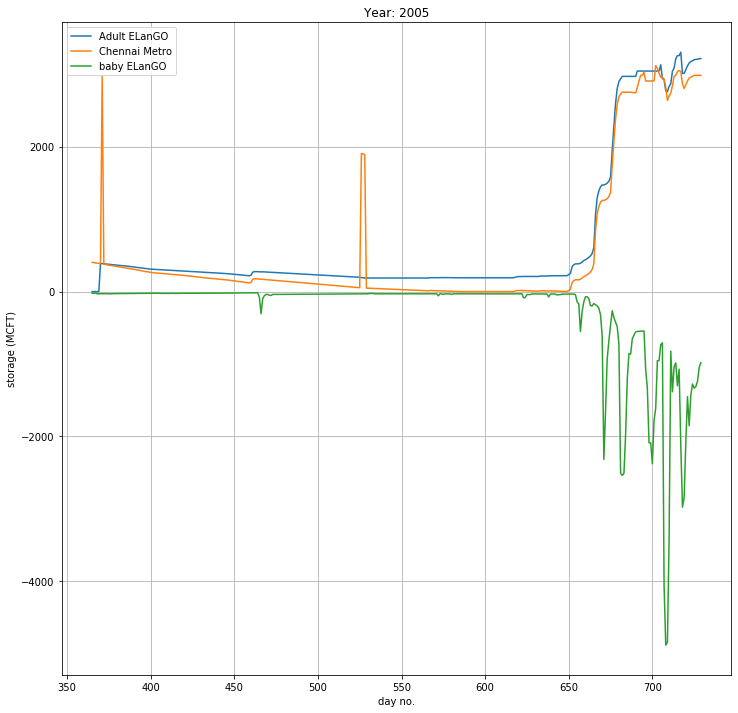

Progress: ------

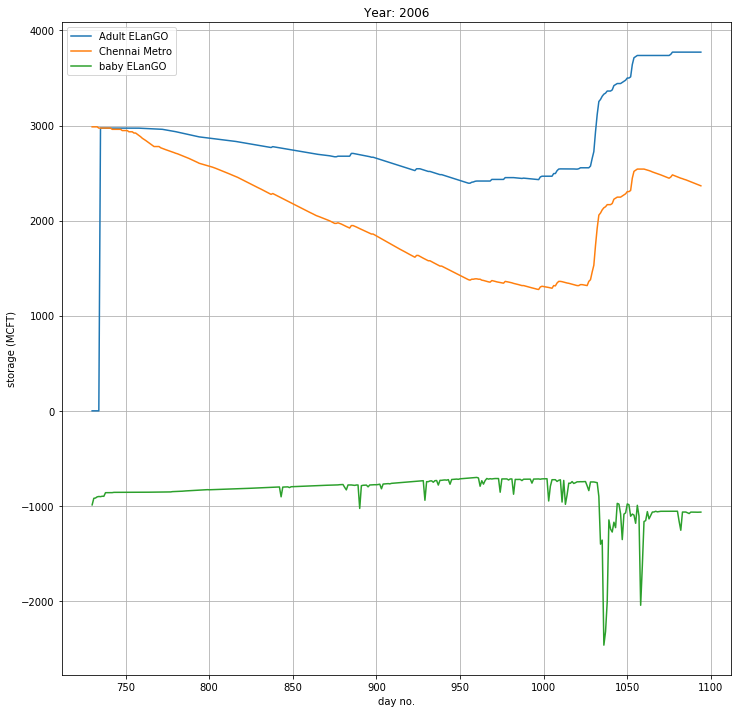

Progress: -------

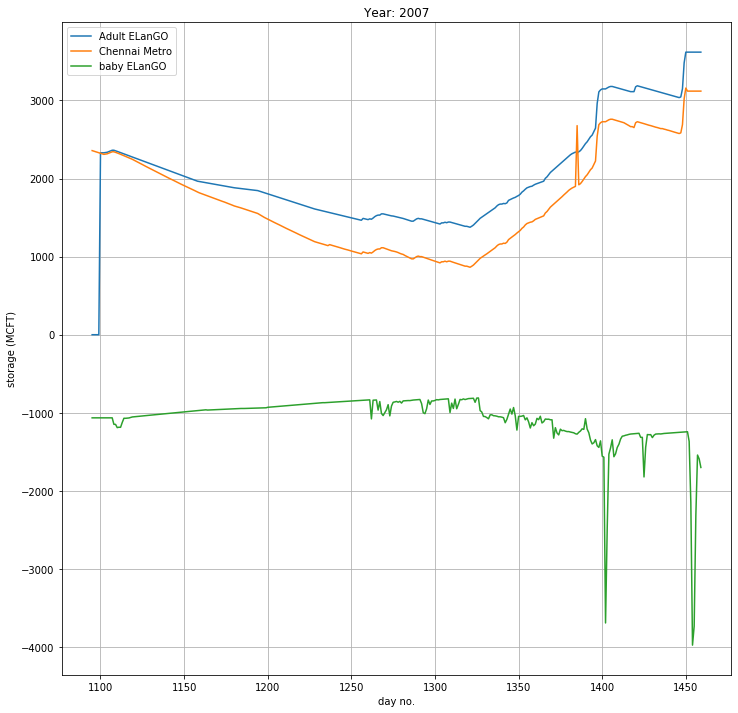

Progress: ------

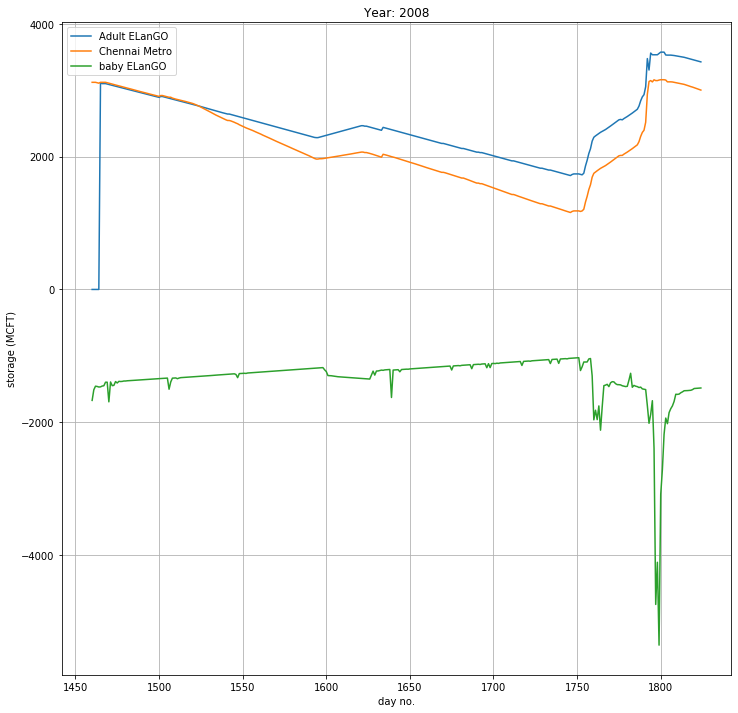

Progress: ------

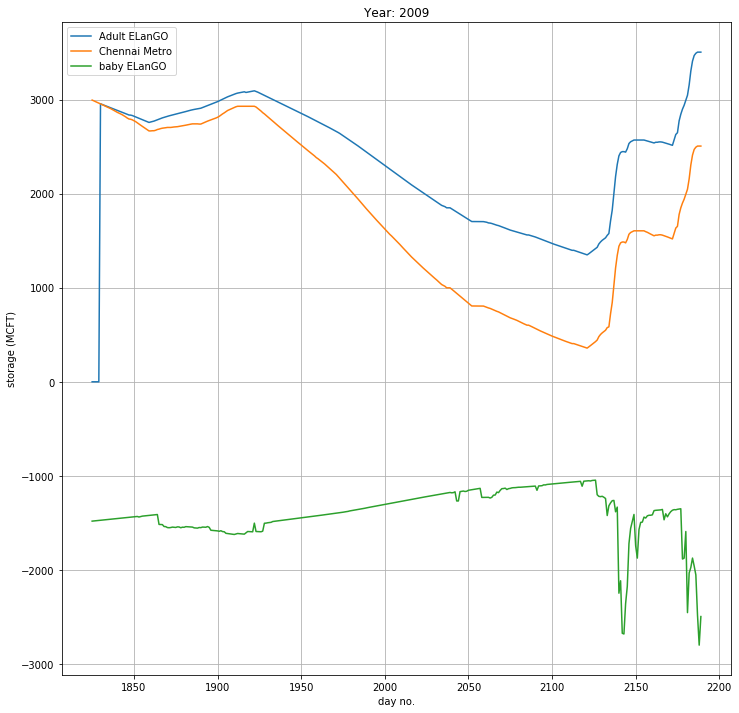

Progress: -------

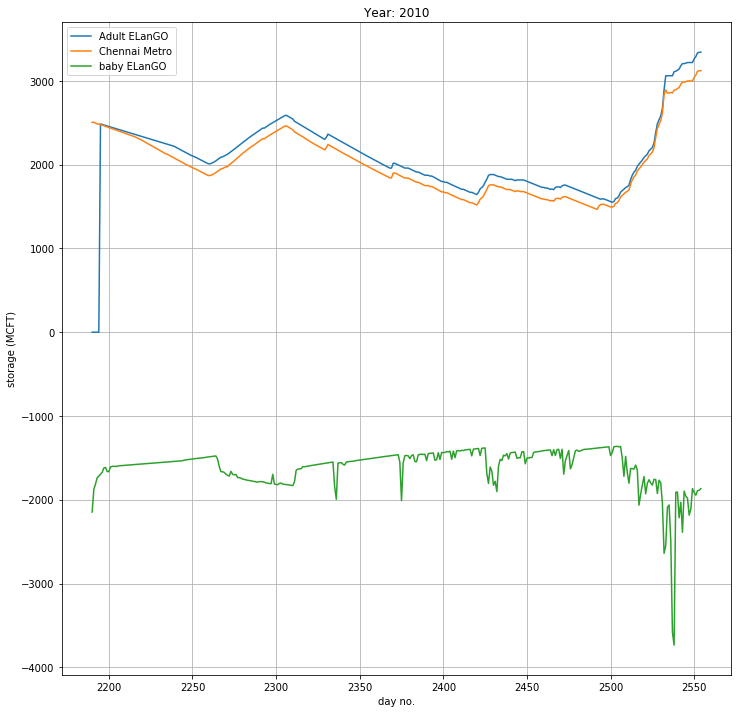

Progress: ------

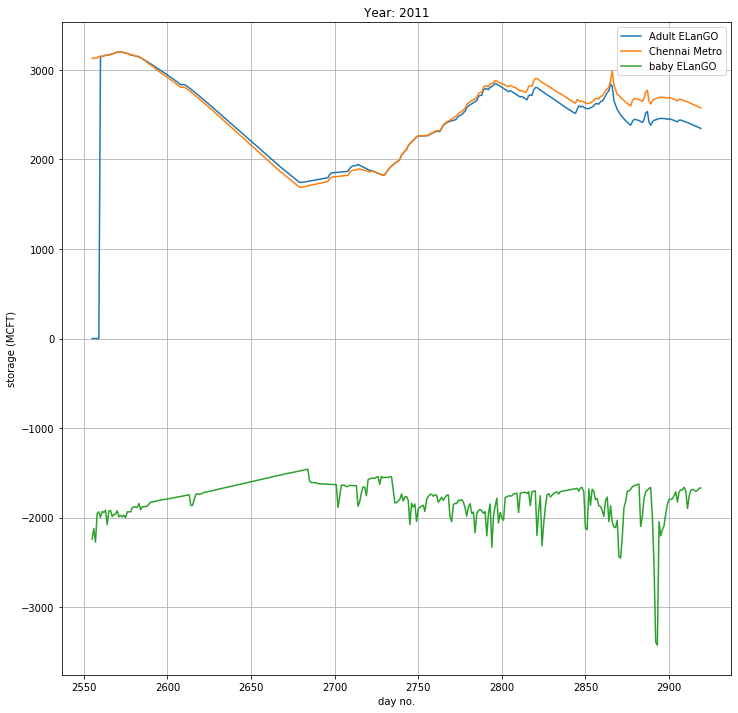

Progress: ------

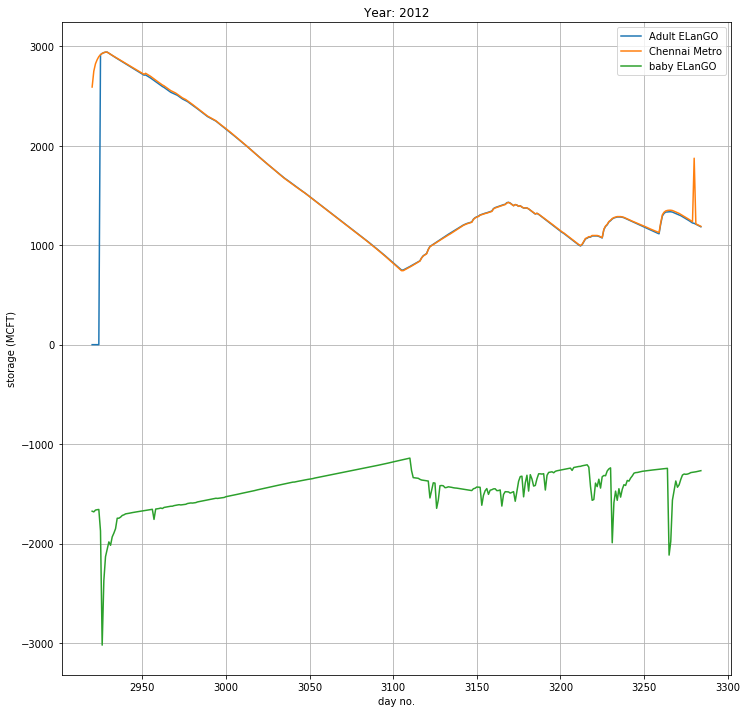

Progress: ------

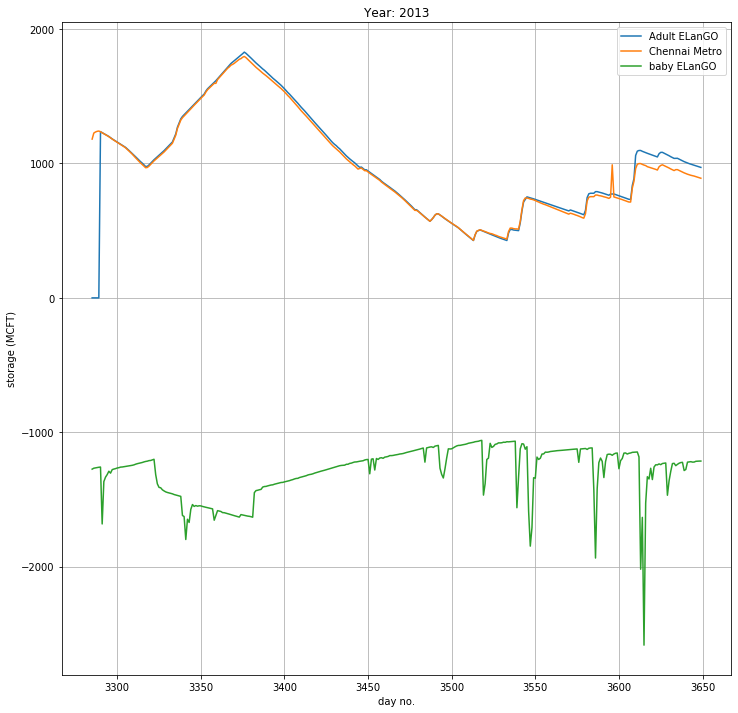

Progress: ------

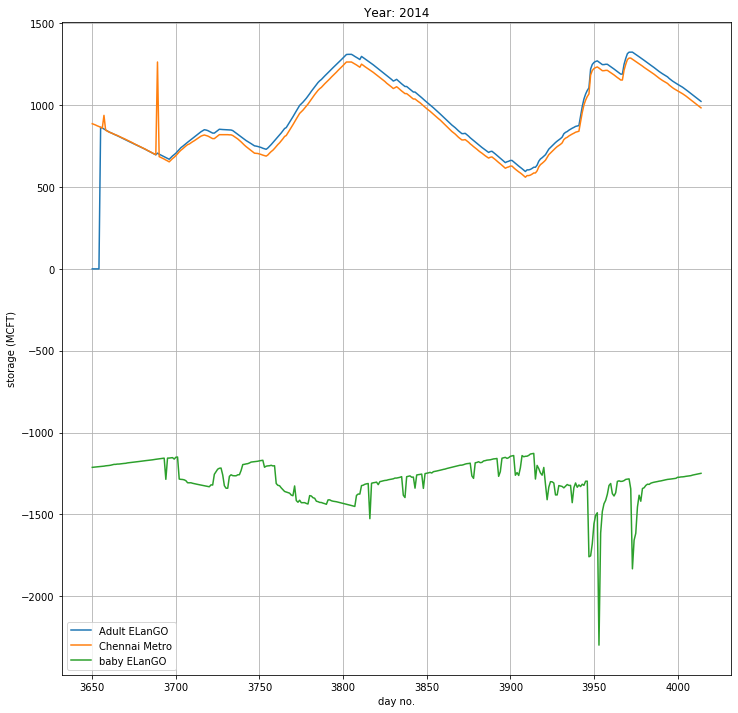

Progress: ------

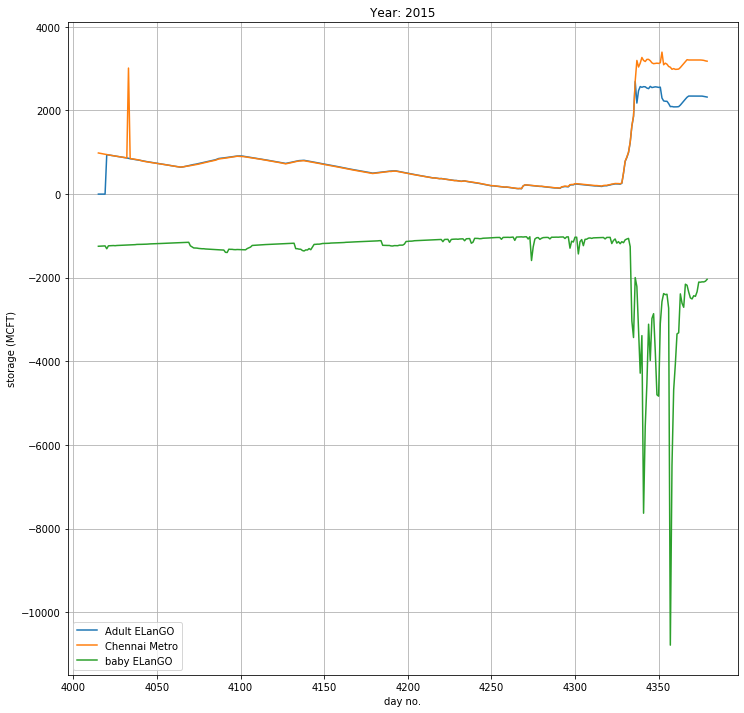

Progress: ------

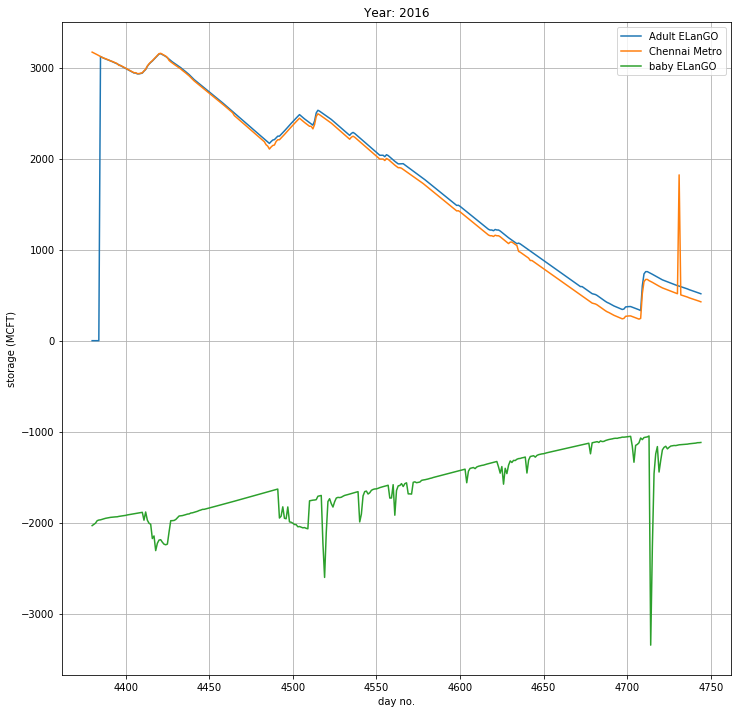

Progress: -------

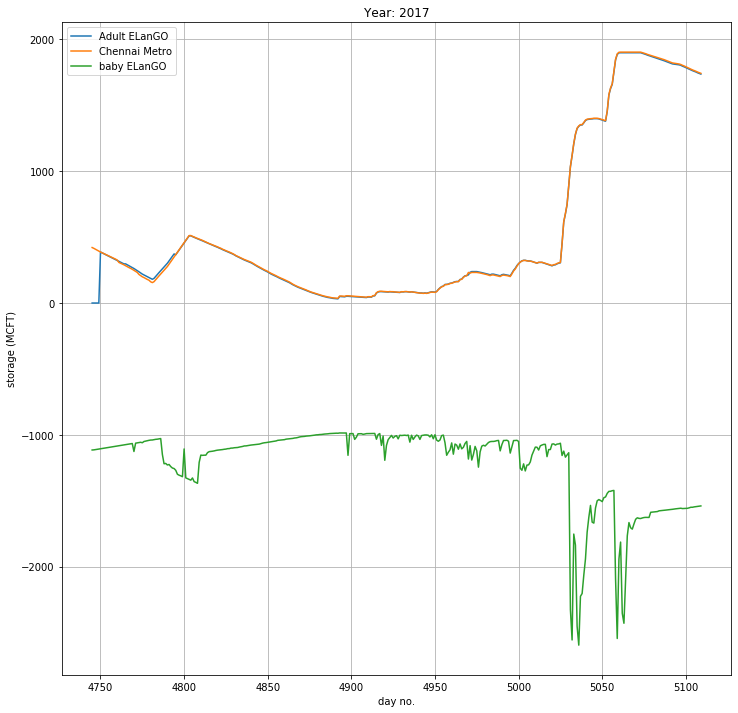

Progress: ------

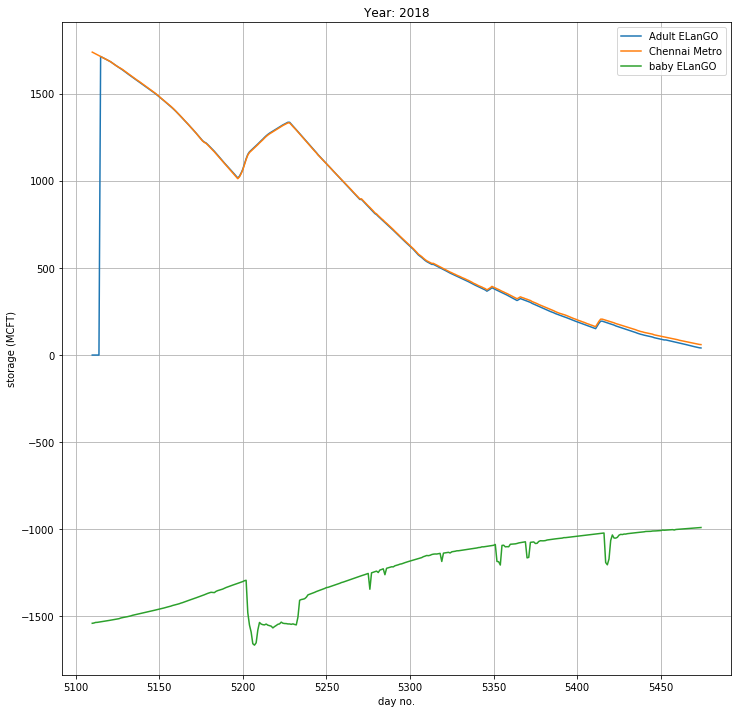

Progress: ------

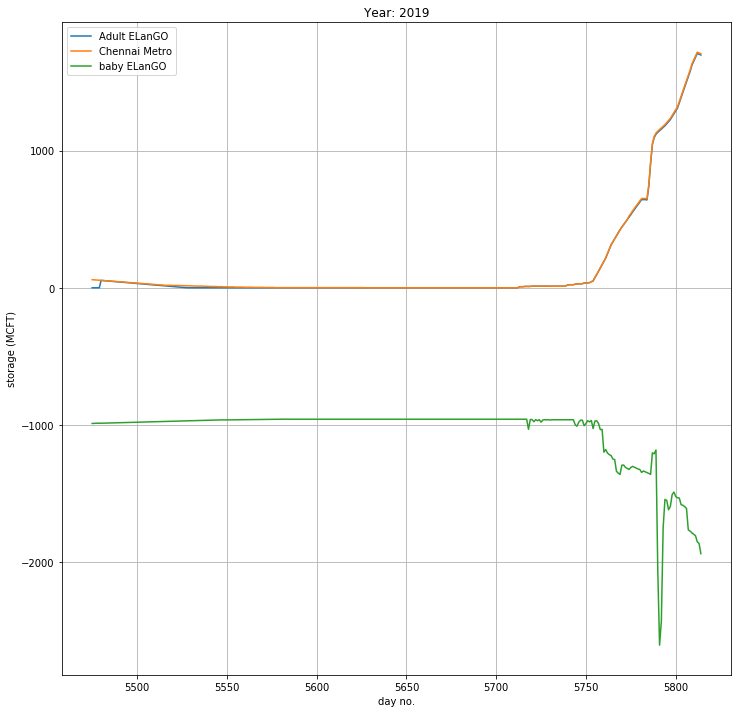

In [98]:

dianna=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\dianna.csv',parse_dates={'date' : ['Date']},na_values=-1)

dianna.dropna(inplace=True)
dianna.info()
dianna=dianna.reset_index()
raw=dianna.drop(columns=['index','date','nth day in year'])
raw.info()
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path


plt.clf()
import matplotlib.pyplot as plt

for ij in range (0,16):

    seed=365*ij

    #env=Chembarambaakam(seed)
    env2=Chembarambaakam(seed)
    
    #env3=Chembarambaakam(seed)
    #env4=Chembarambaakam(seed)
    state2=env2.reset(seed)
    #state3=env3.reset(seed)
    
    #state4=env4.reset(seed)
    #done=False
    done2=False
    #done3=False
    
    #done4=False
    
    i=lookback+seed
    #a=[]
    b=[]
    #c=[]
    #d=[]
    for _ in range(lookback+seed):
        #a.append(0.0)
        b.append(0.0)
        #c.append(0.0)
        #d.append(0.0)
    score=0
    score2=0
    #score3=0

    print('Progress:',end=' ')
    while(not done2):
        #state,reward,done,_=env.step(raw.iloc[i,3])
        #a.append(state[4][0])
        
        state2,reward2,done2,_=env2.step(student.predict(np.array([state2]))[0][0])
        b.append(state2[4][0])
                
        #state3,reward3,done3,_=env3.step(elango.predict(np.array([state3]))[0][0])
        #c.append(state3[4][0])
                
        #state4,reward4,done4,_=env4.step(elango2.predict(np.array([state3]))[0][0])
        #d.append(state4[4][0])
        
        if(i%58==0):
            print('-',end='')
        #score2+=reward2
        i+=1
        if(i>=len(raw) or i>=seed+365):
            break
    

    seed=365*ij
    start=seed
    end=start+365
    if(start+365>len(raw)):
        end=len(raw)-1
    plt.figure(figsize=(12,12))
    plt.plot(range(start,end),b[start:end])
    plt.xlabel('day no.')
    plt.ylabel('storage (MCFT)')
    #plt.plot(range(start,end),a[start:end],linestyle='dashed')
    plt.plot(range(start,end),raw.iloc[start:end,0])
    plt.plot(range(start,end),c[start:end])
    
    #plt.plot(range(start,end),d[start:end])
    plt.legend(['Adult ELanGO','Chennai Metro','baby ELanGO '])
    
    plt.title('Year: '+str(2004+ij))
    plt.grid()

    plt.show()
